In [1]:
import pandas as pd
import numpy as np
import os
from scipy.io import wavfile
import torchaudio
from defs import *
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import timm
from helpers.visualization import visualize_audio
import librosa

/root/anaconda3/envs/album/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/anaconda3/envs/album/lib/python3.10/site-packages/torchaudio/_internal/module_utils.py:99: UserWarning: Failed to import soundfile. 'soundfile' backend is not available.
  warnings.warn("Failed to import soundfile. 'soundfile' backend is not available.")


In [2]:
from featurizers.linear import LinearFeaturizer
from featurizers.spectogram import MelFeaturizer
from models.linear import LinearNet
from models.cnn import CNN
from models.ast import ASTModel
from dataset import SimpleDataset, MixUpDataset
from pl_module import PlModule

In [3]:
df = pd.read_csv('data/ESC-50-master/meta/esc50.csv')

In [4]:
N_MELS = 64
N_LINEAR_FEATURES = 8

dataset = MixUpDataset(df, AUDIO_PATH, TRANSFORM_SET_1)
# dataloader = DataLoader(dataset, batch_size=64)
dataloader = DataLoader(dataset, batch_size=64)
spectogram_featurizer = MelFeaturizer(n_mels=N_MELS)
linear_featurizer = LinearFeaturizer(spectogram_featurizer)
model = ASTModel(50, input_fdim=224, input_tdim=224, model_size="tiny224")
pl_module = PlModule(model, linear_featurizer, torch.nn.BCEWithLogitsLoss, 0.001)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=441


In [5]:
audio, sr = torchaudio.load(os.path.join(AUDIO_PATH, df.filename[0]))

In [6]:
audio.shape

torch.Size([1, 220500])

In [5]:
from torchaudio_augmentations import *

audio, sr = torchaudio.load(os.path.join(AUDIO_PATH, df.filename[0]))

num_samples = sr * 5
transforms = [
    RandomResizedCrop(n_samples=num_samples),
    RandomApply([PolarityInversion()], p=0.8),
    RandomApply([Noise(min_snr=0.001, max_snr=0.005)], p=0.3),
    RandomApply([Gain()], p=0.2),
    HighLowPass(sample_rate=sr), # this augmentation will always be applied in this aumgentation chain!
    RandomApply([Delay(sample_rate=sr)], p=0.5),
    RandomApply([PitchShift(
        n_samples=num_samples,
        sample_rate=sr
    )], p=0.4),
    RandomApply([Reverb(sample_rate=sr)], p=0.3)
]
transforms = [
    RandomApply([PitchShift(
        n_samples=num_samples,
        sample_rate=sr
    )], p=1)
]

In [6]:
transform = Compose(transforms=transforms)
transformed_audio =  transform(audio)

NameError: name 'transforms' is not defined

In [9]:
audio

NameError: name 'audio' is not defined

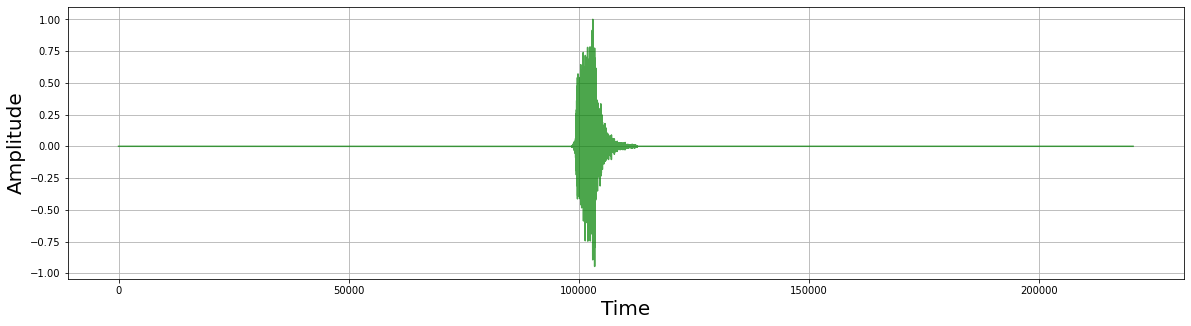

In [23]:
visualize_audio(transformed_audio)

In [6]:
audios, targets = next(iter(dataloader))

In [7]:
audios.shape

torch.Size([64, 1, 220500])

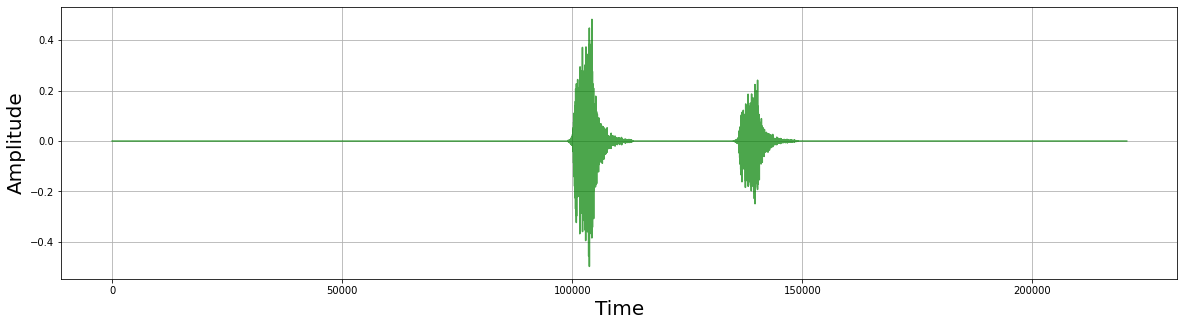

In [9]:
visualize_audio(audios[0])

In [44]:
targets.argmax(1).shape

tensor([ 0, 14,  4, 36, 19, 19, 30, 49,  9, 16, 44, 22, 22, 33,  0, 22,  7,  6,
        48, 34, 48, 22, 22, 27,  9,  1, 31, 17, 21,  8, 15, 35, 15, 46,  9, 37,
        32, 16, 13, 41, 35, 47, 25, 25, 25,  4,  4, 48, 48,  3, 15,  8, 27,  0,
         7, 31, 37,  8, 34,  7, 40, 29, 41, 12])

In [37]:
targets[7].argsort()

tensor([37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36,  1, 38, 39, 40, 41, 42,
        43, 44, 45, 46, 47, 48, 23,  0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
        12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 34, 49])

In [41]:
df.loc[df.target==49]

,filename,fold,target,category,esc10,src_file,take
82,1-18810-A-49.wav,1,49,hand_saw,False,18810,A
121,1-23706-A-49.wav,1,49,hand_saw,False,23706,A
219,1-46353-A-49.wav,1,49,hand_saw,False,46353,A
357,1-7974-A-49.wav,1,49,hand_saw,False,7974,A
358,1-7974-B-49.wav,1,49,hand_saw,False,7974,B
396,1-9886-A-49.wav,1,49,hand_saw,False,9886,A
397,1-9887-A-49.wav,1,49,hand_saw,False,9887,A
398,1-9887-B-49.wav,1,49,hand_saw,False,9887,B
558,2-135860-A-49.wav,2,49,hand_saw,False,135860,A
599,2-184077-A-49.wav,2,49,hand_saw,False,184077,A


In [25]:
torch.unique(targets)

tensor([0.0000, 0.3000, 0.7000, 1.0000], dtype=torch.float64)

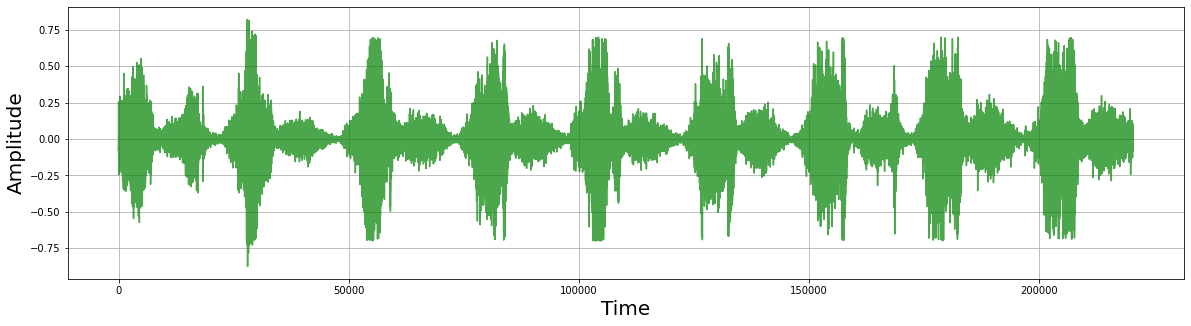

In [35]:
visualize_audio(audios[7][0])

In [9]:
features = spectogram_featurizer(audios)


In [10]:
features.shape

torch.Size([64, 1, 64, 862])

In [7]:
model(features)

tensor([[-0.5205,  0.7333,  0.4740,  ...,  0.4224, -0.0982, -0.2405],
        [-0.8012,  1.1318,  0.1303,  ..., -1.2673,  0.3258,  0.1102],
        [-0.4475,  0.4655,  0.7175,  ..., -1.4979,  0.4783, -0.5718],
        ...,
        [-0.6733,  1.9280,  0.2375,  ..., -0.6422, -0.1121, -0.7920],
        [-0.7778,  0.5833, -0.1581,  ..., -0.0924,  0.0949,  0.7409],
        [-0.0527,  1.5197,  0.7101,  ..., -0.5646,  0.4826, -0.4979]],
       grad_fn=<AddmmBackward0>)

In [19]:
features = spectogram_featurizer(audios)
features = torch.nn.functional.interpolate(features, (224,224))
features = features[:,0,:,:].permute(0,2,1)


In [21]:
model(features)

tensor([[ 0.2515, -0.3733,  0.2337,  ...,  0.6447,  0.1317, -0.0771],
        [-0.1667, -0.1770,  0.7783,  ..., -0.4350, -0.2660,  1.0355],
        [ 0.0861, -0.2777,  0.2476,  ..., -0.4754,  0.3352,  0.3176],
        ...,
        [ 0.1167, -0.4077,  0.9534,  ...,  0.7114, -0.1959,  0.9871],
        [-0.4571, -0.3490,  0.6442,  ..., -0.2818,  0.2888,  0.6017],
        [-0.1643, -0.4219,  0.5296,  ...,  0.2385,  0.1574,  0.3801]],
       grad_fn=<AddmmBackward0>)

In [22]:
interpolated = F.interpolate(features, (224, 244))

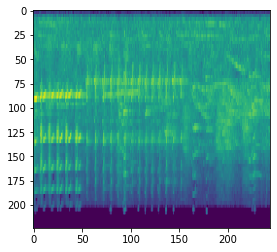

In [24]:
plt.imshow(interpolated[1,0])

In [4]:
df = pd.read_csv('data/ESC-50-master/meta/esc50.csv')

In [51]:
class MelFeaturizer(nn.Module):
    
    def __init__(self, sample_rate=16000, n_fft=1024, win_length=1024, hop_length=256, n_mels=64, center=True):
        super(MelFeaturizer, self).__init__()
        
        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            n_mels=n_mels,
            center=center
        )
        
    def forward(self, wav, length=None):
        mel_spectrogram = self.featurizer(wav)
        mel_spectrogram = mel_spectrogram.clamp(min=1e-5).log()
        
        if length is not None:
            length = (length - self.featurizer.win_length) // self.featurizer.hop_length
            # We add `4` because in MelSpectrogram center==True
            length += 1 + 4
            
            return mel_spectrogram, length
        
        return mel_spectrogram

In [122]:
class LinearFeaturizer(nn.Module):
    def __init__(self, spectogram_featurizer, nan_to_num_value:float=-1) -> None:
        super().__init__()
        self.spectogram_featurizer = spectogram_featurizer
        self.nan_to_num_value = nan_to_num_value

    def forward(self, wav: torch.Tensor) -> torch.Tensor:
        spectogram = self.spectogram_featurizer(wav)
        if len(spectogram.shape) == 3:
            spectogram = spectogram.mean(0)

        mean = torch.mean(spectogram, dim=0)
        diffs = spectogram - mean
        var = torch.mean(torch.pow(diffs, 2.0), dim=0)
        std = torch.pow(var, 0.5)
        zscores = diffs / std
        skews = torch.mean(torch.pow(zscores, 3.0),  dim=0)
        kurtoses = torch.mean(torch.pow(zscores, 4.0),  dim=0) - 3.0 
        
        q25 = spectogram.quantile(0.25, dim=0)
        q50 = spectogram.quantile(0.5, dim=0)
        q75 = spectogram.quantile(0.75, dim=0)
        maxes = spectogram.quantile(1, dim=0)

        features = torch.stack([mean, std, skews, kurtoses, q25, q50, q75, maxes])
        features = features.nan_to_num(self.nan_to_num_value)

        return features.view(-1)



In [107]:
dataset = SimpleDataset(df, AUDIO_PATH)
spectogram_featurizer = MelFeaturizer()
linear_featurizer = LinearFeaturizer(spectogram_featurizer)

In [108]:
wav, label = dataset[1000]

In [113]:
mel_spectrogram = spectogram_featurizer(wav)

In [60]:
mel_spectrogram = mel_spectrogram.squeeze()

In [77]:
mean = torch.mean(mel_spectrogram, dim=0)
diffs = mel_spectrogram - mean
var = torch.mean(torch.pow(diffs, 2.0), dim=0)
std = torch.pow(var, 0.5)
zscores = diffs / std
skews = torch.mean(torch.pow(zscores, 3.0),  dim=0)
kurtoses = torch.mean(torch.pow(zscores, 4.0),  dim=0) - 3.0 

In [90]:
pd.concat(mean, skews)

/tmp/ipykernel_179487/539207410.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat(mean, skews)


TypeError: cannot concatenate object of type '<class 'torch.Tensor'>'; only Series and DataFrame objs are valid

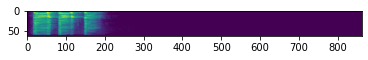

In [48]:
plt.imshow(mel_spectrogram[0])

In [68]:
torch.kurtosis(mel_spectrogram)

AttributeError: module 'torch' has no attribute 'kurtosis'

In [23]:
wav, sr = torchaudio.load(os.path.join(AUDIO_PATH, df.filename[100]))

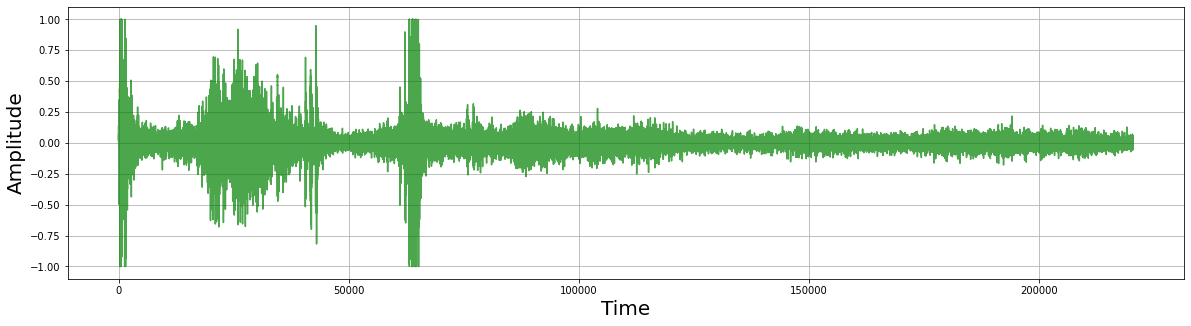

In [24]:
visualize_audio(wav, sr)